<a href="https://colab.research.google.com/github/kode-git/visual-transformers-emotion-recognition/blob/main/Visual_Transformers_for_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Transformers for Emotion Recognition


## 1. Introduction

In Machine Learning, Convolutional Neural Network (CNN) are used usually for object detection and classification. This work will try another configuration based on pre-trained Visual Transformers to obtain a good Face Recognition and, using fine-tuning, train an transformer to encode an image, detect the face and classify its emotion. 

## 2. Data Retrieval

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn as sns
import keras
import os
import cv2

### 2.1 FER2013 Dataset
FER2013 is a dataset composed by 20.000 images on 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). Images are on size 48x48 with gray-scaled colors palette. The classes variations and features distributions are useful in the merging phase for other classes to obtain a good distribution and normalize the amount of data variation. 

In [2]:
num_classes = 7
img_rows, img_cols = 48,48
batch_size = 32

In [3]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!rm challenges-in-representation-learning-facial-expression-recognition-challenge.zip


kaggle.json
/content/data
 94% 269M/285M [00:01<00:00, 182MB/s]
100% 285M/285M [00:02<00:00, 147MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [4]:
FER_train_data_path = "/content/data/train.csv"
FER_test_data_path = "/content/data/test.csv"

We will clone our repository to obtain some important functions in the utils module.

In [5]:
!git clone https://github.com/kode-git/visual-transformers-emotion-recognition.git

Cloning into 'visual-transformers-emotion-recognition'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 6), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [6]:
os.rename("/content/data/visual-transformers-emotion-recognition","/content/data/src_utils")

In [7]:
from src_utils.utils.image_utils import ImageResizer 

In [8]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


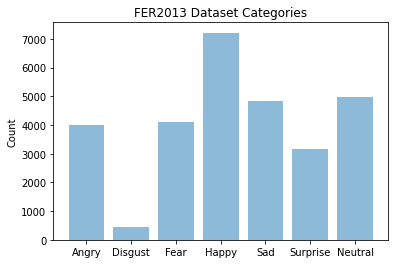

In [9]:
import matplotlib.pyplot as plt

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

FER2013 don't have so many samples for the disgust class. This observation guarantee a good motivation to merge it with other dataset and, also, for data augmentation phase.